Set the various directories and load the model
based on [Deploying Neural Network models to Azure ML Service with Keras and ONNX](http://benalexkeen.com/deploying-neural-network-models-to-azure-ml-service-with-keras-and-onnx/)

Service created in [Deploy ONNX Models](deploy-onnx-models.ipynb)

# Setup environment and Access Service from workspace

In the terminal, created a new enviroment, cloned from azureml_py36 with added required packages:

```
> conda deactivate
> conda create --name azuremlcv_py36 --clone azureml_py36 (had to run 'conda clean -a' first)
> conda activate azuremlcv_py36
> conda install opencv
> python -m ipykernel install --name "azuremlcv_py36" --user
> jupyter kernelspec list
```

In [1]:
import azureml
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.60


In [2]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: dl01
Azure region: uksouth
Subscription id: 51799227-bd67-4e34-96c2-fa93ef5da18d
Resource group: tom


In [3]:
from azureml.core.webservice import AciWebservice, Webservice

service = Webservice(ws, 'caries-filter-onnx-svc')
print(service)

AciWebservice(workspace=Workspace.create(name='dl01', subscription_id='51799227-bd67-4e34-96c2-fa93ef5da18d', resource_group='tom'), name=caries-filter-onnx-svc, image_id=caries-filter-onnx:1, compute_type=ACI, state=Healthy, scoring_uri=http://8da22d10-5819-441b-84b8-2261f811b348.uksouth.azurecontainer.io/score, tags={}, properties={'azureml.git.repository_uri': 'https://github.com/TomosGW/MachineLearningNotebooks.git', 'mlflow.source.git.repoURL': 'https://github.com/TomosGW/MachineLearningNotebooks.git', 'azureml.git.branch': 'MIL/NotebookVM', 'mlflow.source.git.branch': 'MIL/NotebookVM', 'azureml.git.commit': 'ee95b3d6b3f4941bd8cf6d05264d86e1c3d4d1aa', 'mlflow.source.git.commit': 'ee95b3d6b3f4941bd8cf6d05264d86e1c3d4d1aa', 'azureml.git.dirty': 'True'})


In [4]:
print("Scoring API served at: {}".format(service.scoring_uri))

Scoring API served at: http://8da22d10-5819-441b-84b8-2261f811b348.uksouth.azurecontainer.io/score


# Testing our deployed Azure ML API

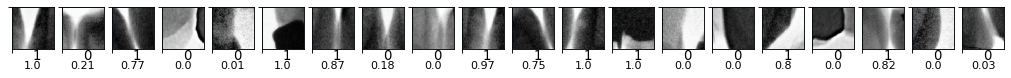

In [33]:
import json 
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import img_to_array
from keras.applications.densenet import preprocess_input
import matplotlib.pyplot as plt

IMAGE_WIDTH, IMAGE_HEIGHT = 120, 120
def preprocess_image(image, size=(IMAGE_WIDTH, IMAGE_HEIGHT)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    image = cv2.resize(image, size)   
    image = preprocess_input(image)
    return image

# Load a series of patch images and evaluate, reporting the results
n_rows = 4
n_cols = 5
n_ptch = n_rows * n_cols
testLabels = [0] * n_ptch
resultLabels = [0] * n_ptch
fig = plt.figure(figsize=(16, 2), dpi= 80, facecolor='w', edgecolor='k')
for i_ptch in range(n_ptch):
    # Tiff image
    filename0 = os.path.join(".","randomPatch%02d_label0.tif" % (i_ptch))
    filename1 = os.path.join(".","randomPatch%02d_label1.tif" % (i_ptch))
    clean_image = []
    if os.path.exists(filename0):
        #print("Loading ", filename0)
        clean_image = cv2.imread(filename0,cv2.IMREAD_GRAYSCALE)
        testLabels[i_ptch] = 0;
    else:
        #print("Loading ", filename1)
        clean_image = cv2.imread(filename1,cv2.IMREAD_GRAYSCALE)
        testLabels[i_ptch] = 1;

    ## Process and analyse the image
    image = cv2.cvtColor(clean_image,cv2.COLOR_GRAY2RGB)
    image = preprocess_image(image)
    data = img_to_array(image)
    data = np.expand_dims(data, axis=0)

    test_samples = json.dumps({"data": data.tolist()})
    test_samples = bytes(test_samples, encoding = 'utf8')

    # predict using the deployed model
    result = service.run(input_data=test_samples)['result']
    resultLabels[i_ptch] = round(result[0][1], 2);
    
    #result_json = {
    #    "normal" : float(result[0][0]),
    #    "caries" : float(result[0][1])
    #}
    
    plt.subplot(1, n_ptch, i_ptch+1)
    plt.axhline('')
    plt.axvline('')
    patch_height, patch_width = clean_image.shape
    plt.text(x = patch_width/2, y = patch_height + 30, s = testLabels[i_ptch], fontsize = 12)
    plt.text(x = patch_width/2, y = patch_height + 55, s = resultLabels[i_ptch], fontsize = 10, horizontalalignment = 'center')
    plt.imshow(clean_image, cmap = plt.cm.Greys)

plt.show()


## Plot patches and results

In [14]:
print(result)
print(result_json)

[[0.9999679327011108, 3.5762786865234375e-05]]
{'normal': 0.9999679327011108, 'caries': 3.5762786865234375e-05}


# URI Request

In [ ]:
import requests

input_data = json.dumps({"data": test_images[sample_indices].tolist()})

headers = {'Content-Type':'application/json'}

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)

result = json.loads(resp.text)['result']

for i, s in enumerate(sample_indices): 
    predicted_value = result[i].index(max(result[i]))
    actual_value = list(test_labels[s]).index(max(test_labels[s]))
    print("{}. Prediction = {}, Actual = {}".format(i, predicted_value, actual_value))